Import all the useful modules

In [7]:
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm # for progress bar

# visualisations
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

# misc
import random as rn
import modules.MainFunctions as MF
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from modules.ShapeGenerator import *

RANDOM_SEED = 42


Load the extension and start TensorBoard

In [2]:

%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11512), started 6 days, 16:45:45 ago. (Use '!kill 11512' to kill it.)

Load the data

In [13]:
#Load the augmented dataset of L. Leprince
file_path = "data/AugmentedLPSpectra/"
files = os.listdir(file_path)
spec_list = []
with tqdm(total=len(files)) as pbar:
    for file in files:
        if file[-4:] == ".npy":
            spec = np.load(file_path+file)
            spec_re, spec_im = np.real(spec),np.imag(spec)
            spec_list.append(np.ravel(np.column_stack((spec_re,spec_im))))
        pbar.update(1)
np1 = np.asarray(spec_list)
df = pd.DataFrame(np1)

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1369.05it/s]


In [20]:
#Load the cuboids
np1=np.load('./data/3DGeneratedCuboids/ravel_spectrums.npy')
df = pd.DataFrame(np1)
print(df.shape)

(12010, 722)


In [160]:
#load the trigonometric function shapes
np1=np.load('./data/3DGeneratedRadius/ravel_spectrums.npy')
df = pd.DataFrame(np1)
print(df.shap

(60010, 722)


Randomize X

In [14]:
X= df.to_numpy()
np.random.shuffle(X)


Choose a smaller X if needed

In [15]:
X=X[:10000]

Prepare RY for faster visualisation

In [16]:
N=50
Lmax=18
savePath='data/precomputedRY/'
big_RY=MF.find_RY(N,Lmax,RY_PATH=savePath)

Loading data/precomputedRY/RY_M_100_Lmax_18_.npy


Visualise one random shape deducted from the spectrum

<IPython.core.display.Javascript object>


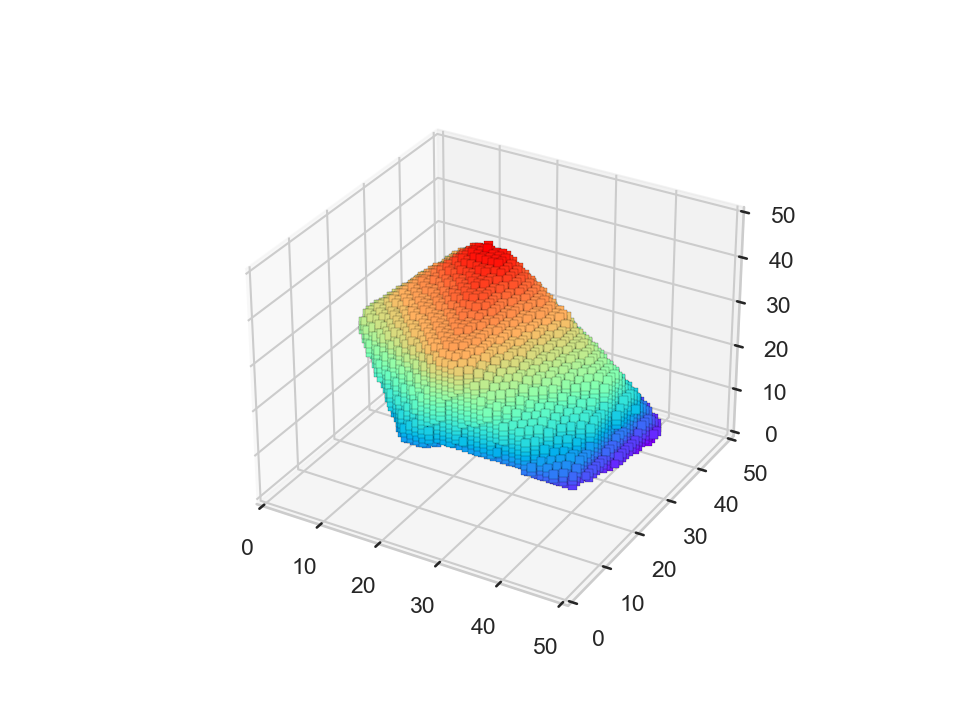

In [17]:
def ravel_spectrum_to_complex(X):
    return X[::2] + 1.j*X[1::2]

def show_shape_from_spectrum(c,N,big_RY):
    np.save('./tmp/tmp',ravel_spectrum_to_complex(c))
    b=[25,25,25]
    RY= MF.extract_RY(big_RY,N,b)
    shape=MF.recompose("./tmp/tmp.npy",N,b,RY=RY)[0]
    show_shape(np.argwhere(shape==1),N)


k=np.random.randint(len(X))
show_shape_from_spectrum(X[k],N,big_RY)


Check what the coefficients look like 

In [18]:

def show_spectrums(X,symlog=True):
    tmp=np.tile(np.arange(len(X[0])),[len(X),1] )
    x=np.ravel(X)
    y=np.ravel(tmp)

    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.tight_layout()
    plt.subplot(2, 2, 1)
    plt.scatter(y[::2]/2,x[::2],alpha=0.1,s=0.1)
    plt.title('real part')
    if symlog:
        plt.yscale('symlog')

    plt.subplot(2, 2, 2)
    plt.scatter((y[1::2]-1)/2,x[1::2],alpha=0.1,s=0.1,color='green')
    plt.title('imaginary part')
    if symlog:
        plt.yscale('symlog')
    plt.show()
    
    Xr=X[:,::2]
    Xi=X[:,1::2]
    plt.subplot(2, 2, 3)
    x=np.mean(np.abs(Xr),axis=0)
    y=np.arange(len(Xr[0]))
    plt.plot(y,x)
    if symlog:
        plt.yscale('symlog')
    plt.title('abs real part - mean')
    plt.show()
    
    plt.subplot(2, 2, 4)
    x=np.mean(np.abs(Xi),axis=0)
    y=np.arange(len(Xi[0]))
    plt.plot(y,x)
    if symlog:
        plt.yscale('symlog')
    plt.title('abs imaginary part - mean')
    plt.show()
    
    return


<IPython.core.display.Javascript object>


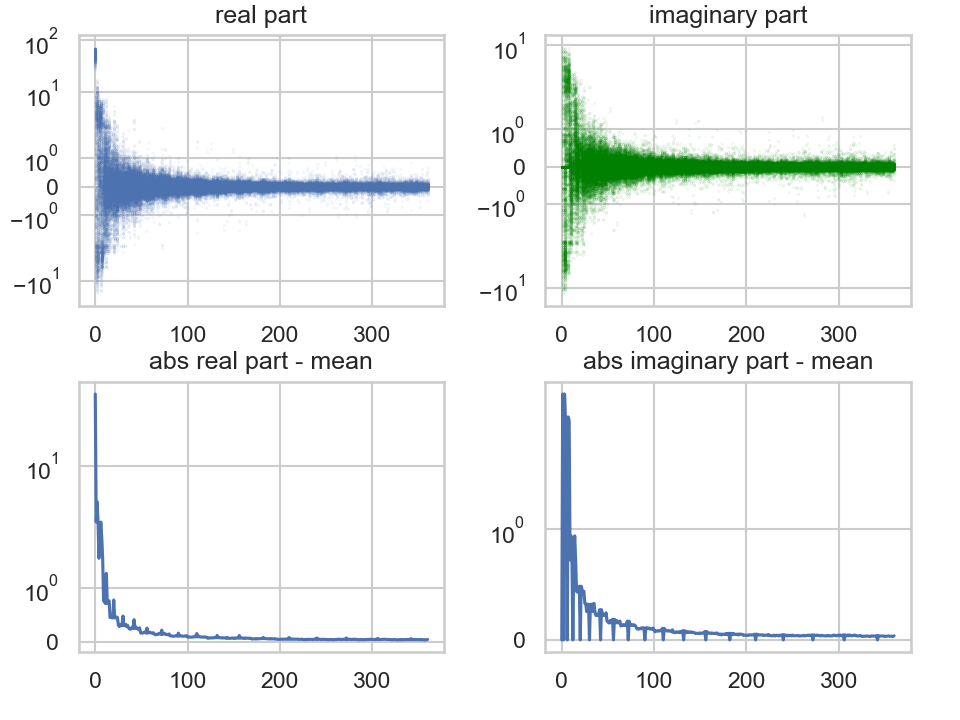

In [19]:
show_spectrums(X[:500])

In [20]:
def plot_coef_histo(X,K):
        
    fig, axes = plt.subplots(nrows=len(K), ncols=2)
    fig.tight_layout()
    fig.set_figheight(4*len(K))
    fig.set_figwidth(8)
    i=0
    for k in K:
        Lmax=int(np.sqrt(k))
        m=k-Lmax**2-Lmax
        i+=1
        xr=X[:,2*k]
        xi=X[:,2*k+1]
        plt.subplot(len(K), 2, i)
    
        counts, bins = np.histogram(xr)
        plt.hist(bins[:-1], bins, weights=counts)
        


        plt.title('coordinate ' +str(2*k)+ "; Lmax = "+str(Lmax) + " ; m = "+str(m)+' - real part')
        
        i+=1
        plt.subplot(len(K), 2, i)

        counts, bins = np.histogram(xi)
        plt.hist(bins[:-1], bins, weights=counts)
        plt.subplot(len(K), 2, i)

        plt.title('coordinate ' +str(2*k)+ "; Lmax = "+str(Lmax) + " ; m = "+str(m)+' - imaginary part')

    plt.show()
        

<IPython.core.display.Javascript object>


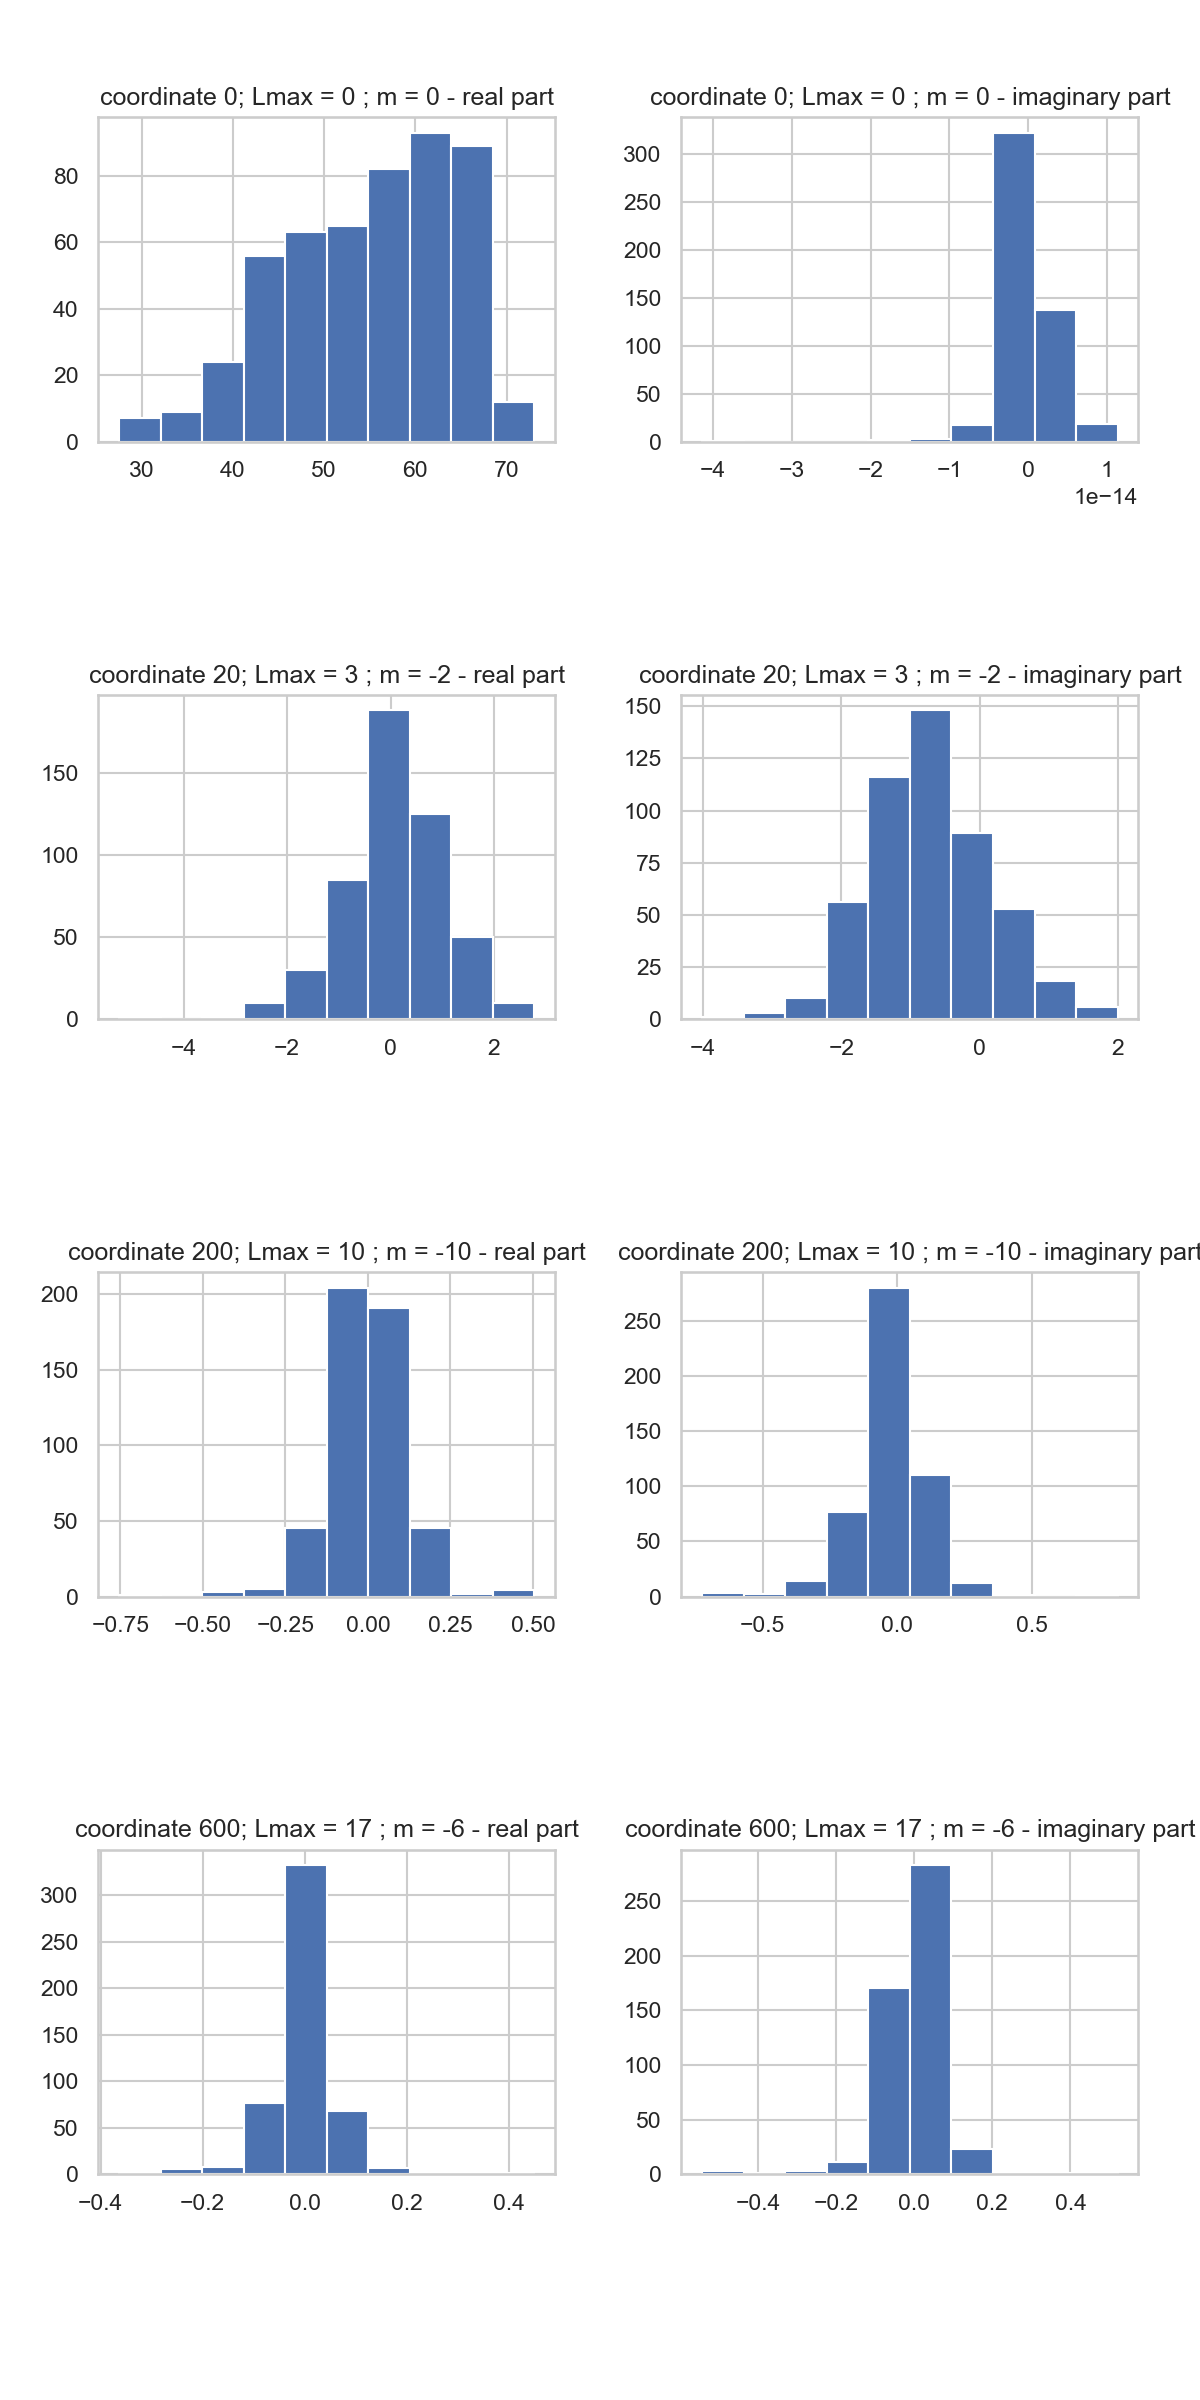

In [21]:
plot_coef_histo(X[:500],[0,10,100,300])

Correlation between coefficients

<IPython.core.display.Javascript object>


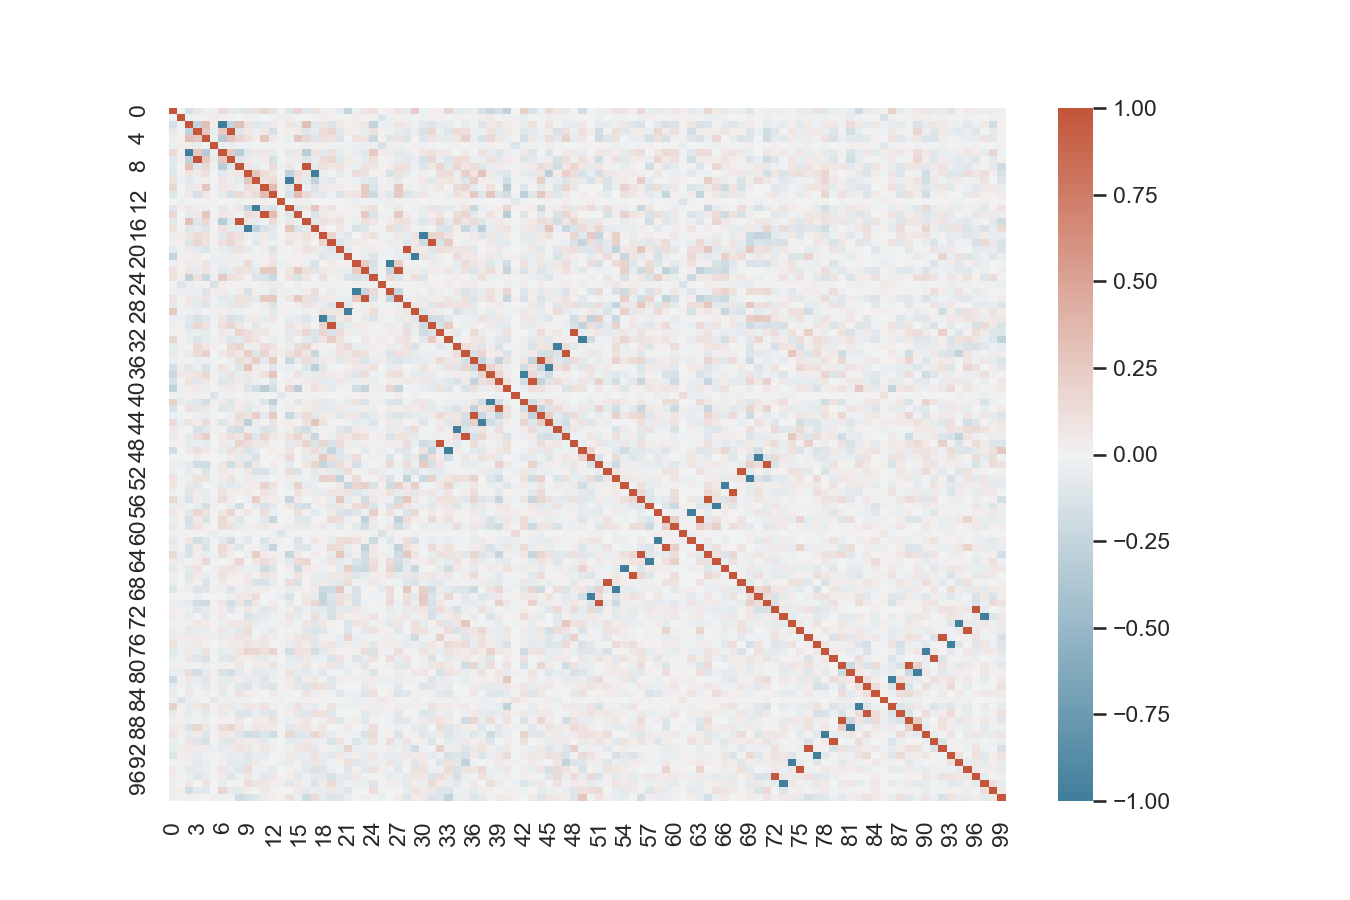

<AxesSubplot:>

In [22]:
corr=(df.iloc[:5000,:100]).corr()

f, ax = plt.subplots(figsize=(9, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=False, cmap=cmap)




Rescale each coefficient so that the autoencodeur is not biased by the first ones

In [23]:
rescaling=2


if rescaling==1:
    #no modification
    def rescale(X):
        return X

    def descale(X2):
        return X2
    
elif rescaling==2:
    #0-1 rescaled
    scaler = MinMaxScaler(feature_range=(0, 1))
    def rescale(X):
        return scaler.fit_transform(X)

    def descale(X2):
        return scaler.inverse_transform(X2)
    
elif rescaling==3:
    #standardization
    scaler = StandardScaler()
    def rescale(X):
        scaler.fit(X)
        return scaler.transform(X)

    def descale(X2):
        return scaler.inverse_transform(X2)
    
elif rescaling==4:
    #0-1 decreasing rescaled
    scaler = MinMaxScaler(feature_range=(0, 1))
    def rescale(X):
        return np.tile([1/(1+np.arange(len(X[0])))],(len(X),1))*scaler.fit_transform(X)

    def descale(X2):
        A=X2*np.tile([(1+np.arange(len(X2[0])))],(len(X2),1))
        return scaler.inverse_transform(A)
    
elif rescaling==5:
    #0-1 linear decreasing rescaled
    scaler = MinMaxScaler(feature_range=(0, 1))

    def rescale(X):
        return np.tile([(1000-np.arange(len(X[0])))],(len(X),1))*scaler.fit_transform(X)

    def descale(X2):
        A=X2*np.tile([1/(1000-np.arange(len(X2[0])))],(len(X2),1))
        return scaler.inverse_transform(A)
    
    

In [24]:
X2=rescale(X)
X3=descale(X2)
print(np.all(1e-5>(X - X3)))

True


Check how the new spectrum looks like

<IPython.core.display.Javascript object>


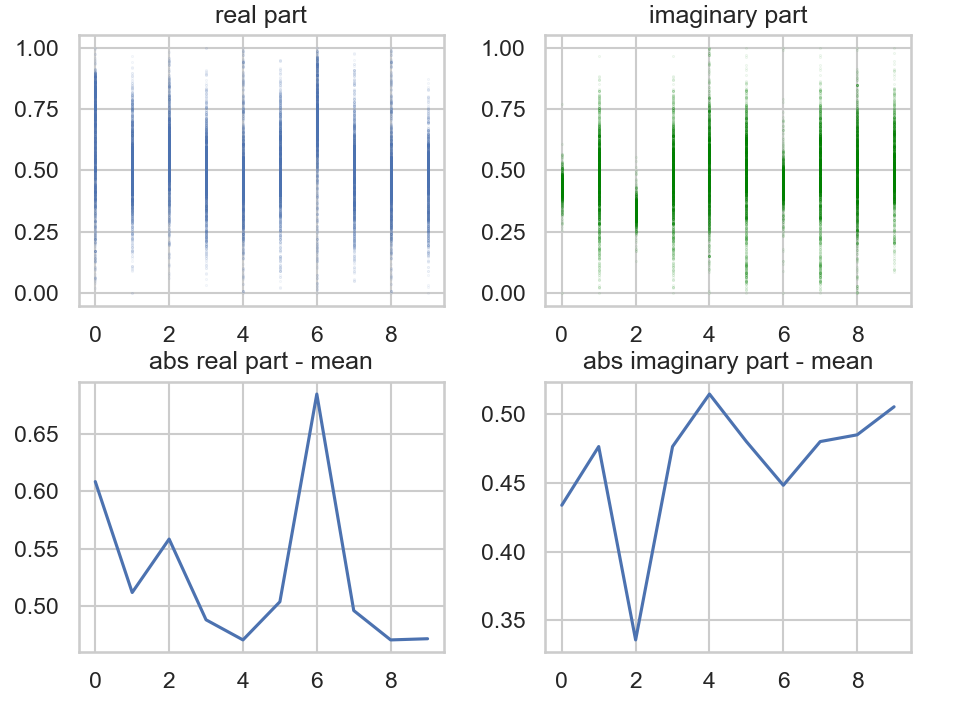

In [25]:
show_spectrums(X2[:2000,:20],symlog=False)

Define train, test and validate set

In [26]:
train_ratio=0.8
test_ratio=0.1

L=len(X2)

X_train = X2[:int(L*train_ratio)]
X_test  = X2[int(L*train_ratio):int(L*train_ratio)+int(L*test_ratio)]
X_validate = X2[int(L*train_ratio)+int(L*test_ratio):]

print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)


(4800, 722)
(600, 722)
(600, 722)


Define the architecture

In [28]:
# This is the size of our encoded representations
encoding_dim = 64  

# This is our input image
input_img = tf.keras.Input(shape=(len(X[0]),))

# "encoded" is the encoded representation of the input
encoded = tf.keras.layers.Dense(254, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = tf.keras.layers.Dense(254, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(len(X[0]), activation='sigmoid')(decoded)

# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)

# This is our encoded input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

# Create the decoder model
decoded1 = autoencoder.layers[-2](encoded_input)
# This is the second layer
decoded2 = autoencoder.layers[-1](decoded1)
# Finally, the decoder
decoder = tf.keras.Model(encoded_input, decoded2)

autoencoder.compile(optimizer='adam', loss='mse',metrics=['mae'])

# print an overview of our model
autoencoder.summary();

# print an overview of the encoder
encoder.summary();

# print an overview of the decoder
decoder.summary();


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 722)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 254)               183642    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16320     
_________________________________________________________________
dense_6 (Dense)              (None, 254)               16510     
_________________________________________________________________
dense_7 (Dense)              (None, 722)               184110    
Total params: 400,582
Trainable params: 400,582
Non-trainable params: 0
_________________________________________________________________
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output 

Launch training

In [31]:
history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=8,
                shuffle=True,
                validation_data=(X_validate, X_validate))

Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: 0.0025 - mae: 0.0357 - val_loss: 0.0028 - val_mae: 0.0372
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 0.0025 - mae: 0.0358 - val_loss: 0.0028 - val_mae: 0.0377
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 0.0025 - mae: 0.0357 - val_loss: 0.0028 - val_mae: 0.0373
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 0.0025 - mae: 0.0354 - val_loss: 0.0029 - val_mae: 0.0378
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 0.0025 - mae: 0.0357 - val_loss: 0.0028 - val_mae: 0.0371
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 0.0025 - mae: 0.0354 - val_loss: 0.0028 - val_mae: 0.0377
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 0.0025 - mae: 0.0356 - val_loss: 0.0028 - val_mae: 0.0373
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 0.

Check the training and validation loss across epochs

<IPython.core.display.Javascript object>


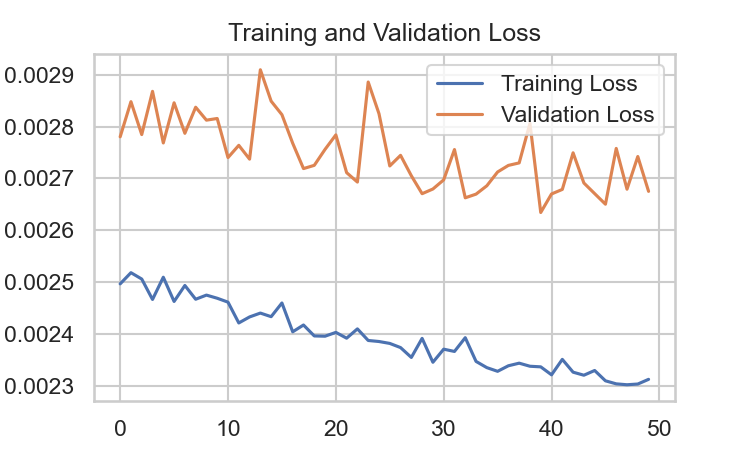

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))



plt.figure(figsize=(5, 3))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
def MSE(x,y):
    return np.mean(np.array(x-y)**2)

def MAE(x,y):
    return np.mean(np.abs(np.array(x-y)))

In [34]:
# pass the transformed test set through the autoencoder to get the reconstructed result
pX_test = autoencoder.predict(X_test)
pX_train = autoencoder.predict(X_train)
pX_validate = autoencoder.predict(X_validate)

In [35]:
print(MSE(pX_test,X_test))
print(MSE(pX_train,X_train))
print(MSE(pX_validate,X_validate))

0.002797156795724187
0.0022499565009611693
0.0026751448610088826


In [36]:
print(MAE(pX_test,X_test))
print(MAE(pX_train,X_train))
print(MAE(pX_validate,X_validate))

0.03694976667659596
0.033991842808994234
0.03652664448361224


Check manually random shape predictions

In [37]:
def show_2_shapes(list_vertices,N=0):
      
    
    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize=plt.figaspect(0.45))
    i=0
    #===============
    #  First subplot
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    X=list_vertices[i][:,0]
    Y=list_vertices[i][:,1]
    Z=list_vertices[i][:,2]
    ax.scatter(X,Y,Z,c=Z,marker="s",alpha=1,cmap="rainbow",edgecolor='black', linewidth=0.1)

    #===============
    # Second subplot
    #===============
    i+=1
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    X=list_vertices[i][:,0]
    Y=list_vertices[i][:,1]
    Z=list_vertices[i][:,2]
    ax.scatter(X,Y,Z,c=Z,marker="s",alpha=1,cmap="rainbow",edgecolor='black', linewidth=0.1)

    plt.show()

In [38]:
def compare_spectrums_3D(c1,c2,big_RY,rescale=True,N=50):
    if rescale:
        c1=descale(np.array([c1]))[0]
        c2=descale(np.array([c2]))[0]
    np.save('./tmp/tmp',ravel_spectrum_to_complex(c1))
    b=[25,25,25]
    RY= MF.extract_RY(big_RY,N,b)
    shape1=MF.recompose("./tmp/tmp.npy",N,b,RY=RY)[0]
    np.save('./tmp/tmp',ravel_spectrum_to_complex(c2))
    shape2=MF.recompose("./tmp/tmp.npy",N,b,RY=RY)[0]
    show_2_shapes([np.argwhere(shape1==1),np.argwhere(shape2==1)],N)
    

    

<IPython.core.display.Javascript object>


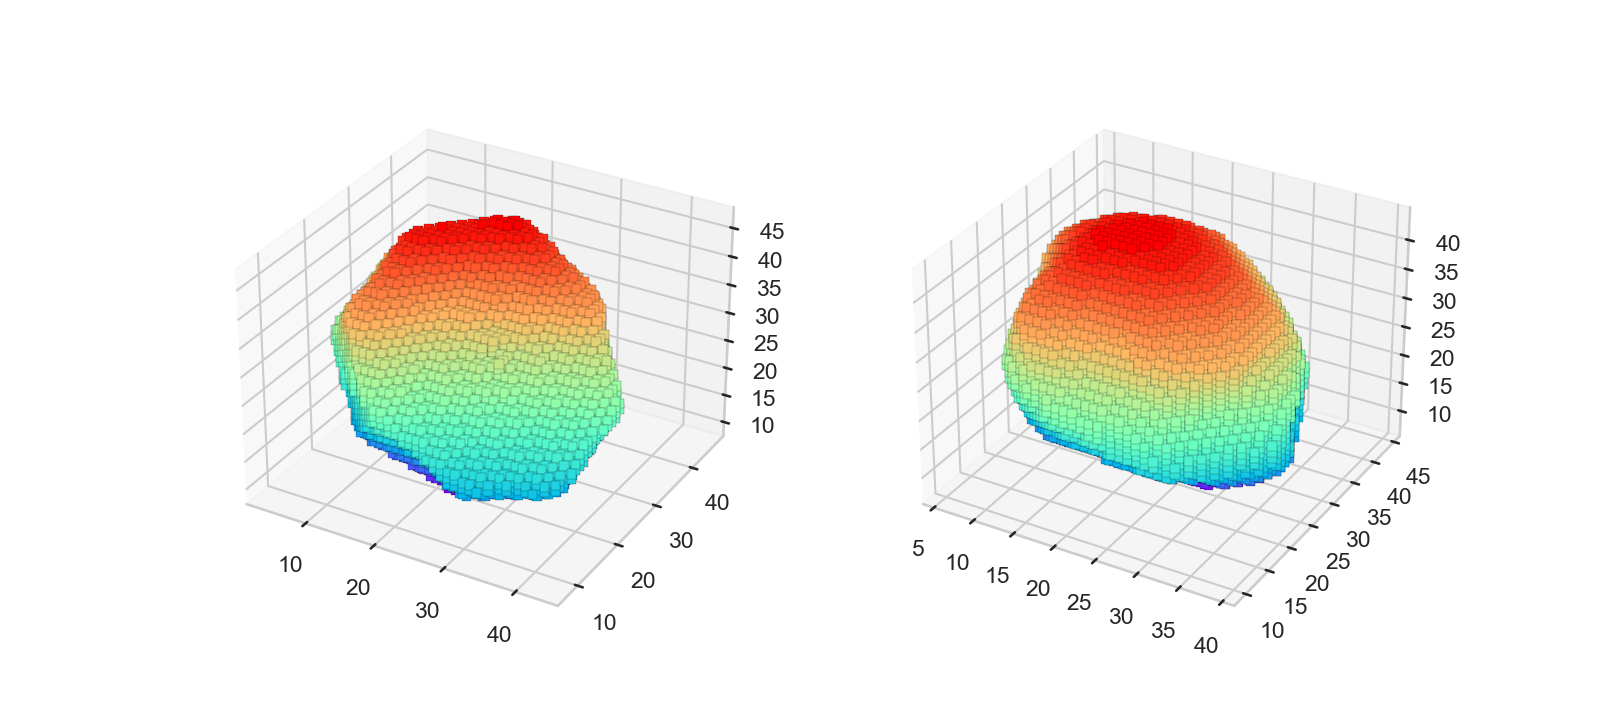

In [39]:
X0=X_test
k=np.random.randint(len(X0))
x=X0[k]
y=autoencoder.predict(np.array([x]))[0]

compare_spectrums_3D(x,y,big_RY)

Check the coefficients prediction 

In [40]:
def plot_spectrums_pred(X,K,rescale=False):
    Y=autoencoder.predict(X)
    if rescale:
        X=descale(X)
        Y=descale(Y)
    i=0
    
    fig, axes = plt.subplots(nrows=len(K), ncols=2)
    fig.tight_layout()
    fig.set_figheight(4*len(K))
    fig.set_figwidth(8)
    
    for k in K:
        Lmax=int(np.sqrt(k))
        m=k-Lmax**2-Lmax
        i+=1
        xr=X[:,2*k]
        xi=X[:,2*k+1]
        yr=Y[:,2*k]
        yi=Y[:,2*k+1]
        plt.subplot(len(K), 2, i)
        plt.scatter(xr,yr,alpha=0.5,s=1)
        mx, b = np.polyfit(xr, yr, 1)
        plt.plot(xr, mx*xr + b,'--',label='y={:.2f}x+{:.2f}'.format(mx,b),alpha=0.2)
        #plt.plot(xr, xr,'--',color='red',alpha=0.2)
        plt.legend(fontsize=9)
        plt.xlabel('true value')
        plt.ylabel('predicted')

        plt.title('coordinate ' +str(2*k)+ "; Lmax = "+str(Lmax) + " ; m = "+str(m)+' - real part')
        
        i+=1
        plt.subplot(len(K), 2, i)
        plt.scatter(xi,yi,alpha=0.5,s=1)
        mx, b = np.polyfit(xi, yi, 1)
        plt.plot(xi, mx*xi + b,'--',label='y={:.2f}x+{:.2f}'.format(mx,b),alpha=0.2)
        #plt.plot(xi, xi,'--',color='red',alpha=0.2)
        plt.legend(fontsize=9)
        plt.xlabel('true value')
        plt.ylabel('predicted')

        plt.title('coordinate ' +str(k)+ "; Lmax = "+str(Lmax) + " ; m = "+str(m)+' - imaginary part')

    plt.show()
 
    
    

<IPython.core.display.Javascript object>


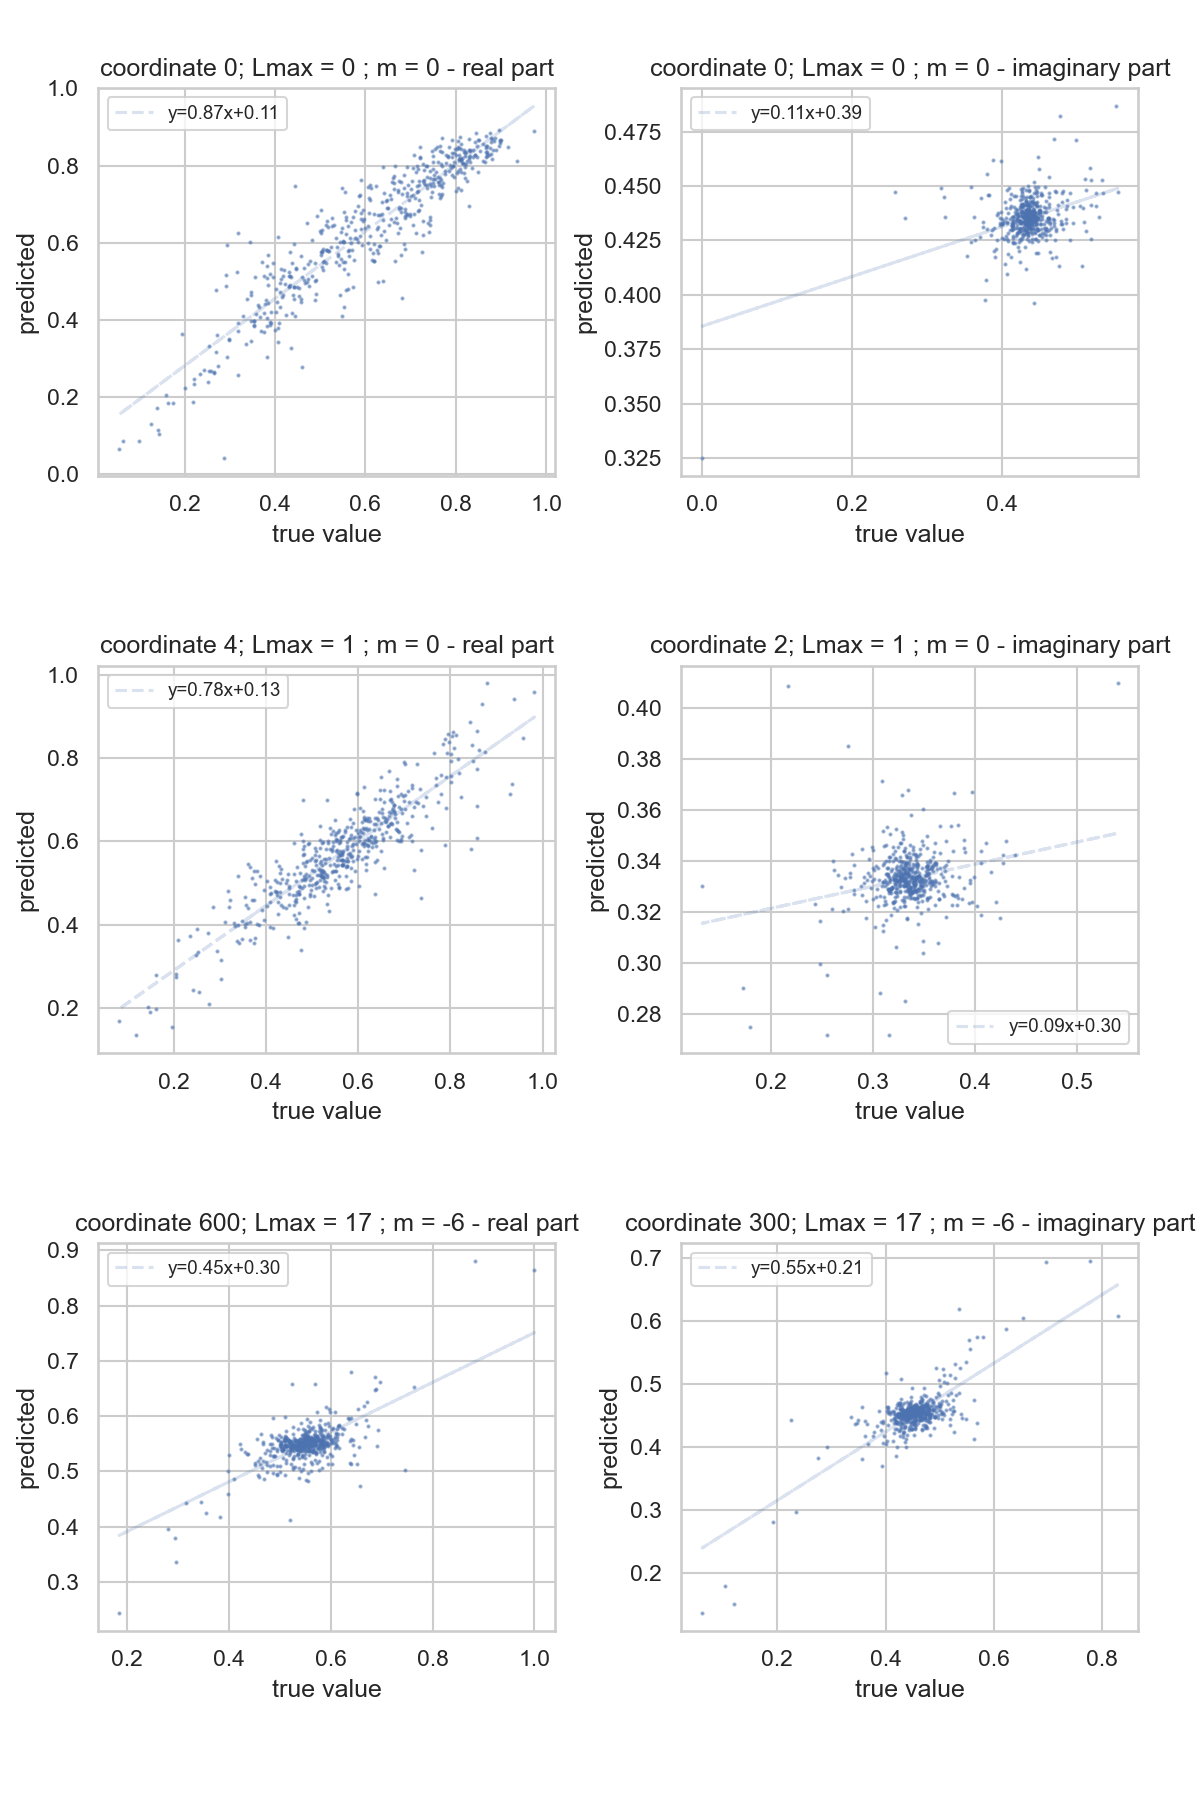

In [41]:
plot_spectrums_pred(X_train[:500],[0,2,300])

Check coefficients correlation

<IPython.core.display.Javascript object>


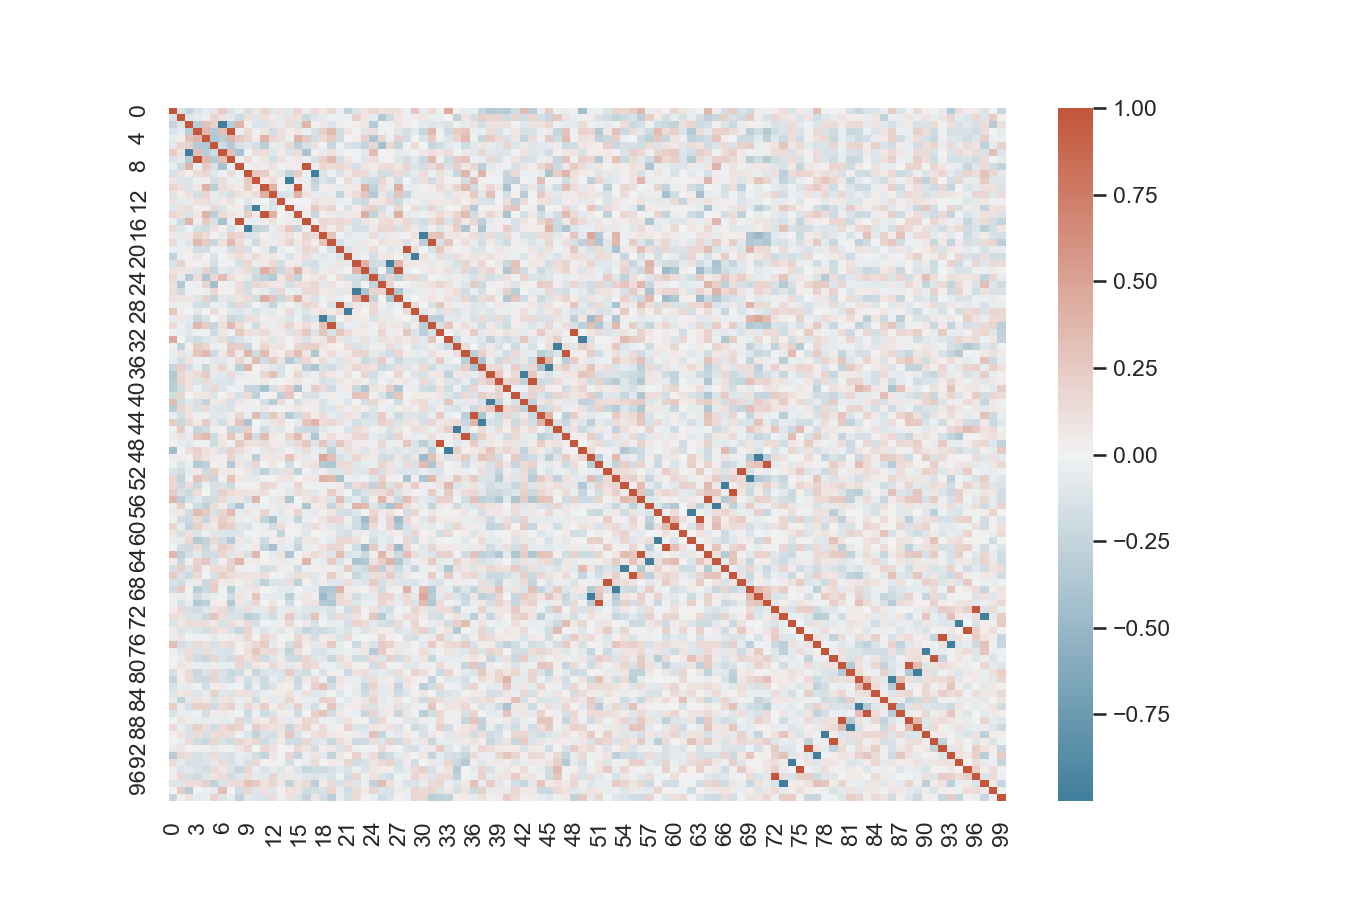

<AxesSubplot:>

In [42]:
corr=(pd.DataFrame(pX_test).iloc[:500,:100]).corr()

f, ax = plt.subplots(figsize=(9, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=False, cmap=cmap)



In [43]:
def plot_shape_error(X,big_RY,rescale=False):
    Y=autoencoder.predict(X)
    if rescale:
        X=descale(X)
        Y=descale(Y)
    b=[25,25,25]
    N=50
    errors=[]
    for i in range(len(X)):
        print("\r"+str(i)+"/"+str(len(X)), end="\r")
        xi=X[i]
        yi=Y[i]
        np.save('./tmp/tmp',ravel_spectrum_to_complex(xi))
        RY=MF.extract_RY(big_RY,N,b)
        sx=MF.recompose("./tmp/tmp.npy",N,b,RY=RY)[0]
        np.save('./tmp/tmp',ravel_spectrum_to_complex(yi))
        sy=MF.recompose("./tmp/tmp.npy",N,b,RY=RY)[0]
        ei=MF.error(1*sx,1*sy)
        errors.append(ei/100)
    print("Mean error is : "+str(np.mean(errors)))
    counts, bins = np.histogram(errors)
    fig, ax = plt.subplots()
    ax.hist(bins[:-1], bins, weights=counts)
    plt.title('3D shape error repartition')
    plt.show()
        
    

Mean error is : 0.2751073569886828


<IPython.core.display.Javascript object>


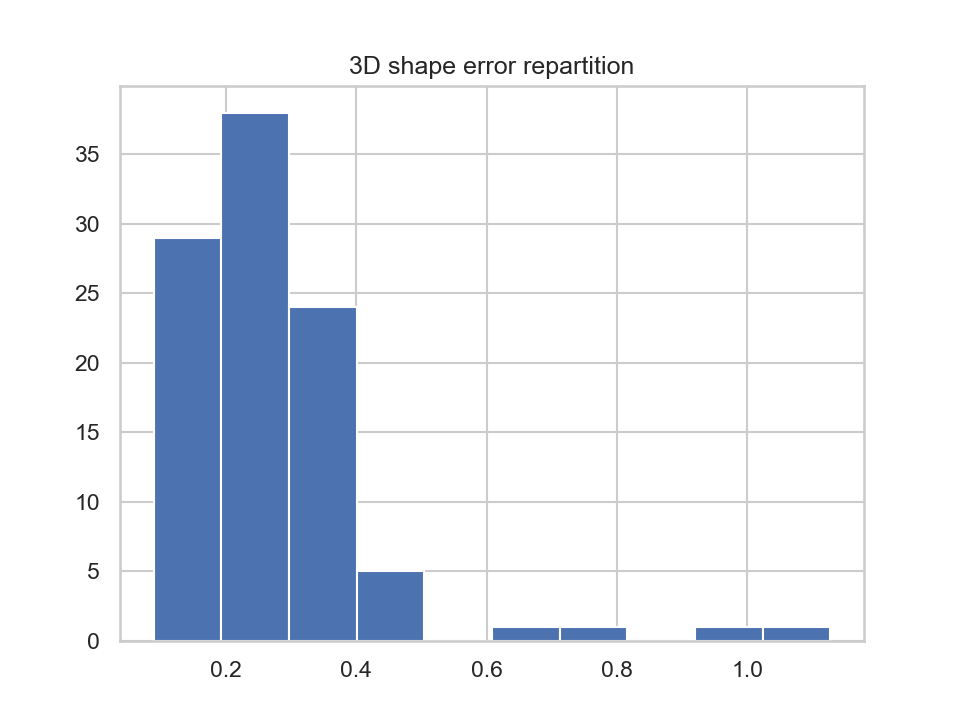

In [44]:
plot_shape_error(X_test[:100],big_RY,True)

Generate shapes from the latent space

<IPython.core.display.Javascript object>


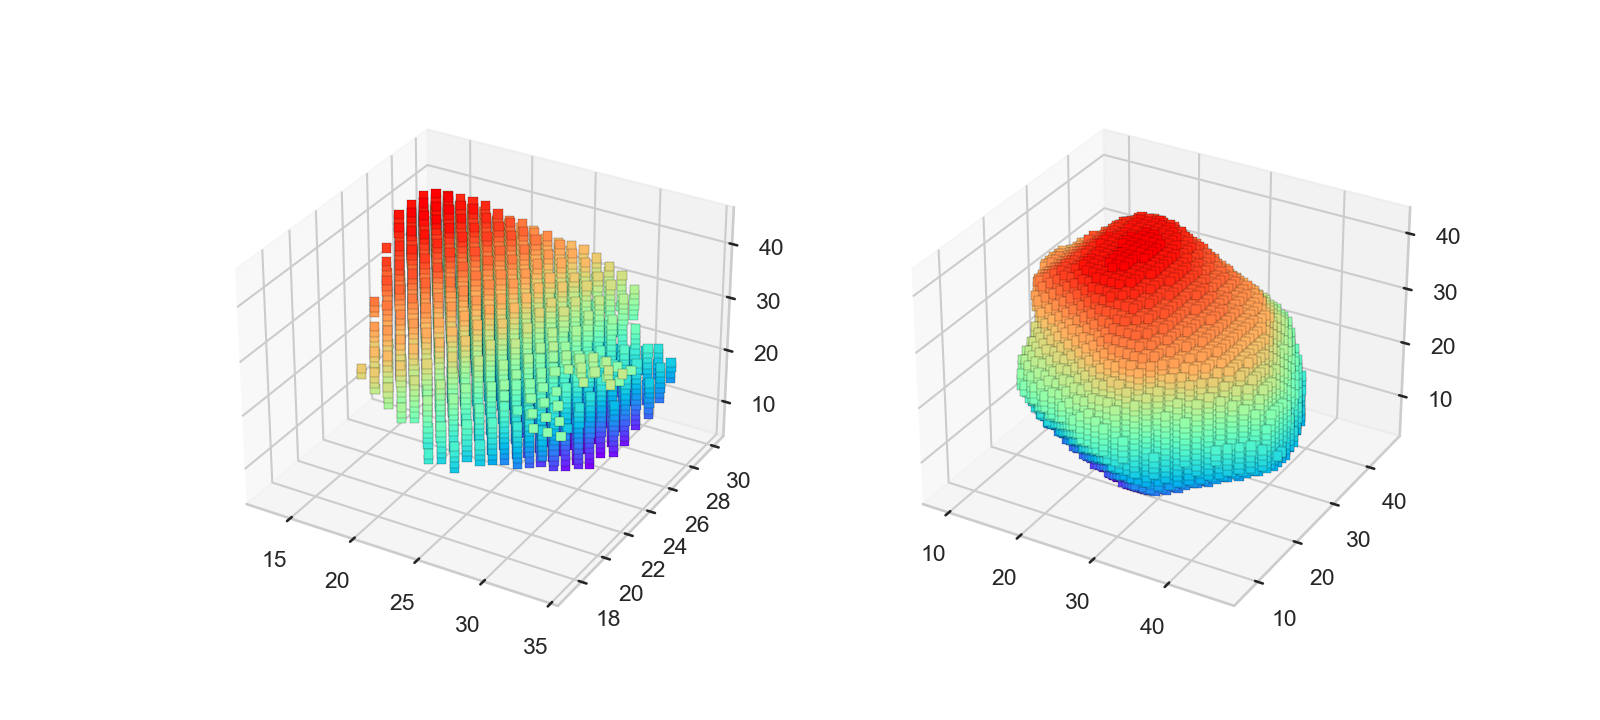

In [50]:
#Select two initial shapes

X0=X_test
k1=np.random.randint(len(X0))
k2=np.random.randint(len(X0))
x1=X0[k1]
x2=X0[k2]
z1=encoder.predict(np.array([x1]))[0]
z2=encoder.predict(np.array([x2]))[0]
y1=decoder.predict(np.array([z1]))[0]
y2=decoder.predict(np.array([z2]))[0]

compare_spectrums_3D(y1,y2,big_RY)


In [51]:
#Generate m new shapes
m=10
Z=[z1+i*(z2-z1)/m for i in range(m+1)]
Y=[decoder.predict(np.array([z]))[0] for z in Z]


<IPython.core.display.Javascript object>


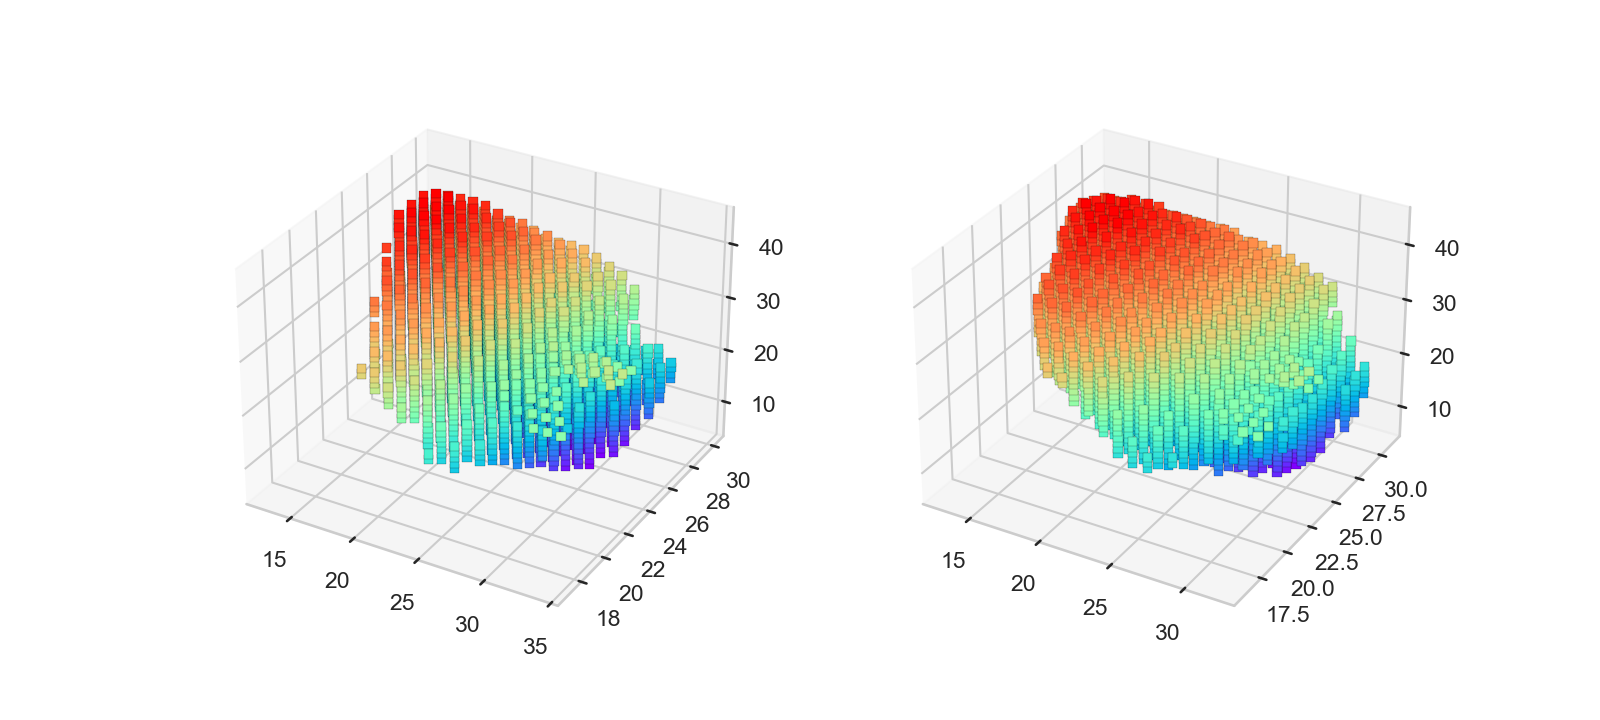

<IPython.core.display.Javascript object>


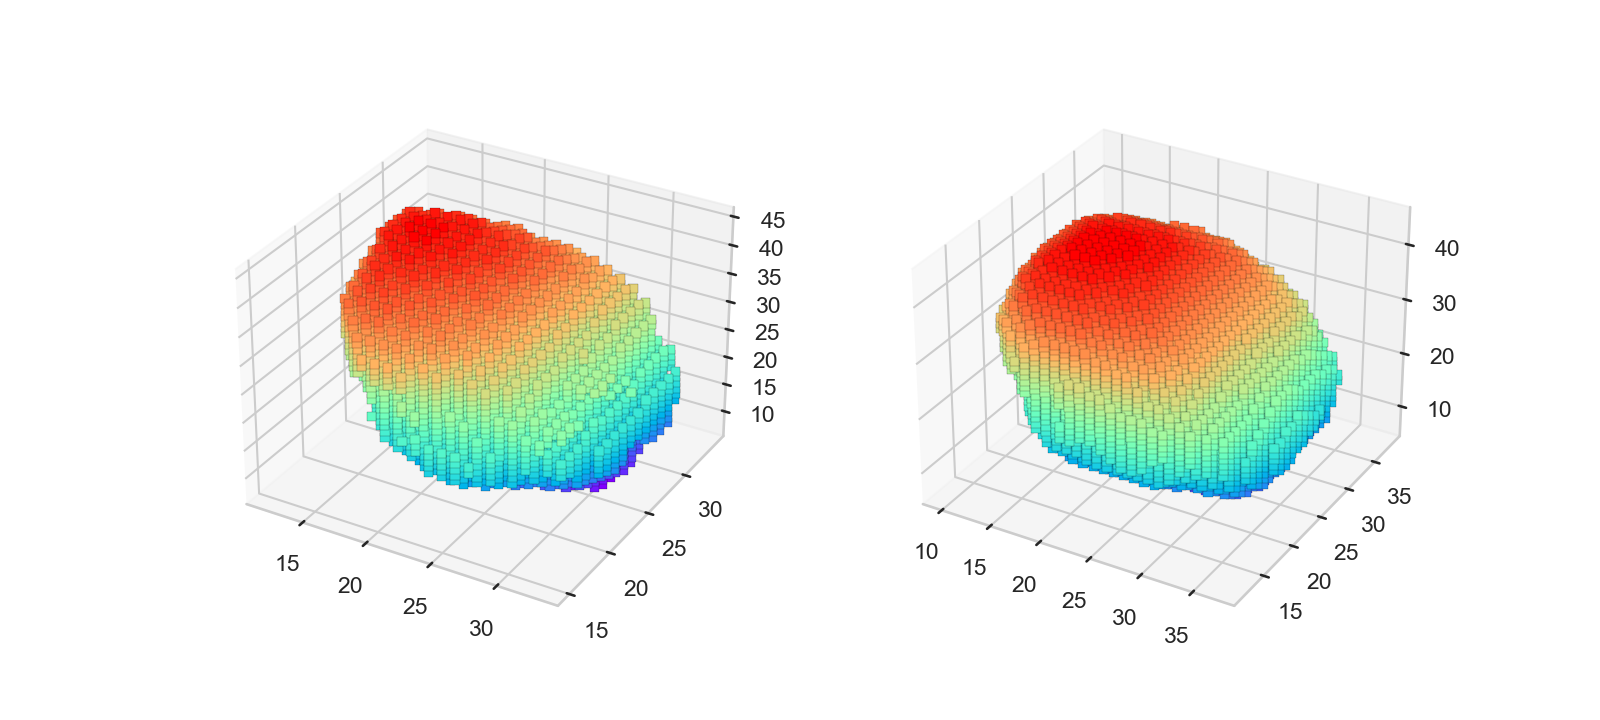

<IPython.core.display.Javascript object>


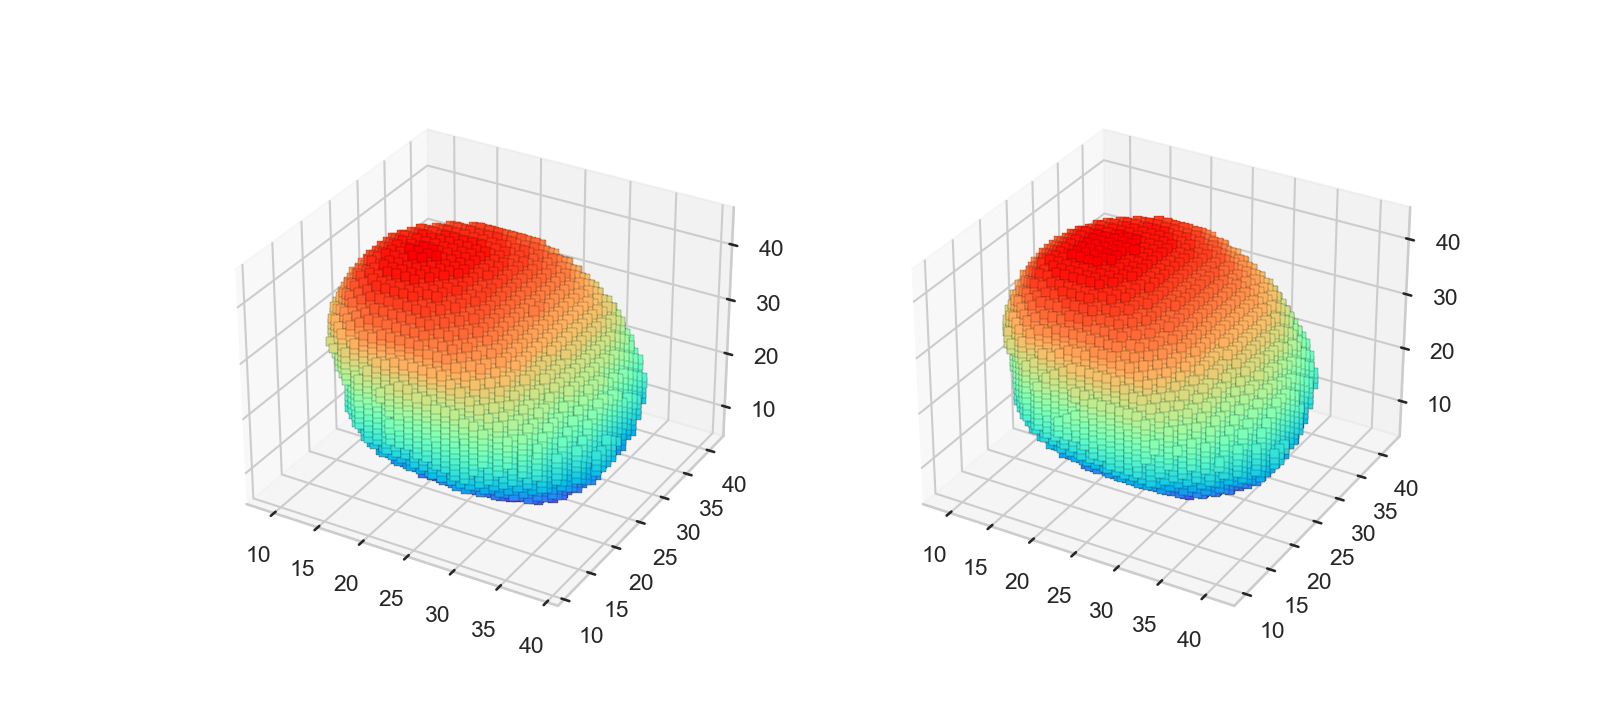

<IPython.core.display.Javascript object>


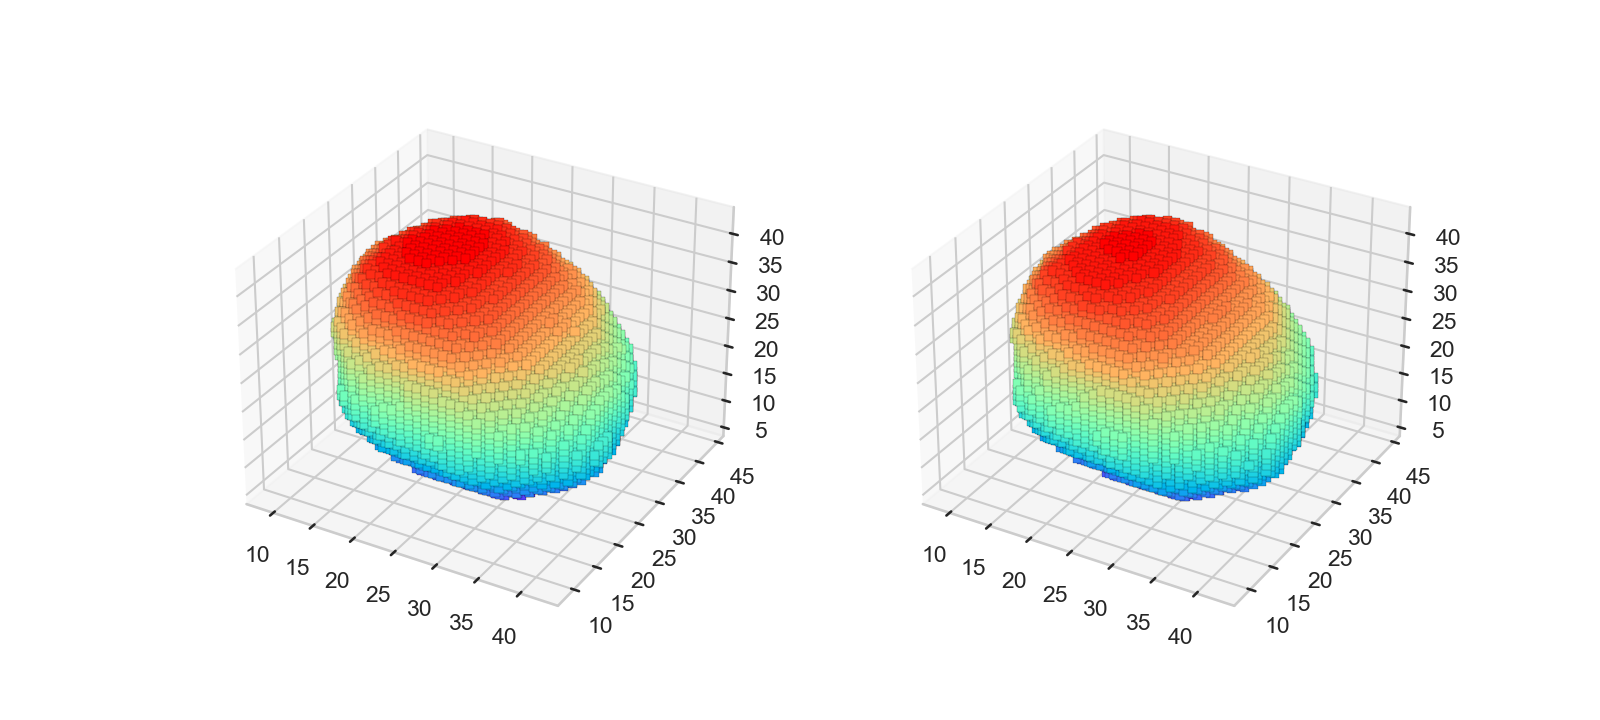

<IPython.core.display.Javascript object>


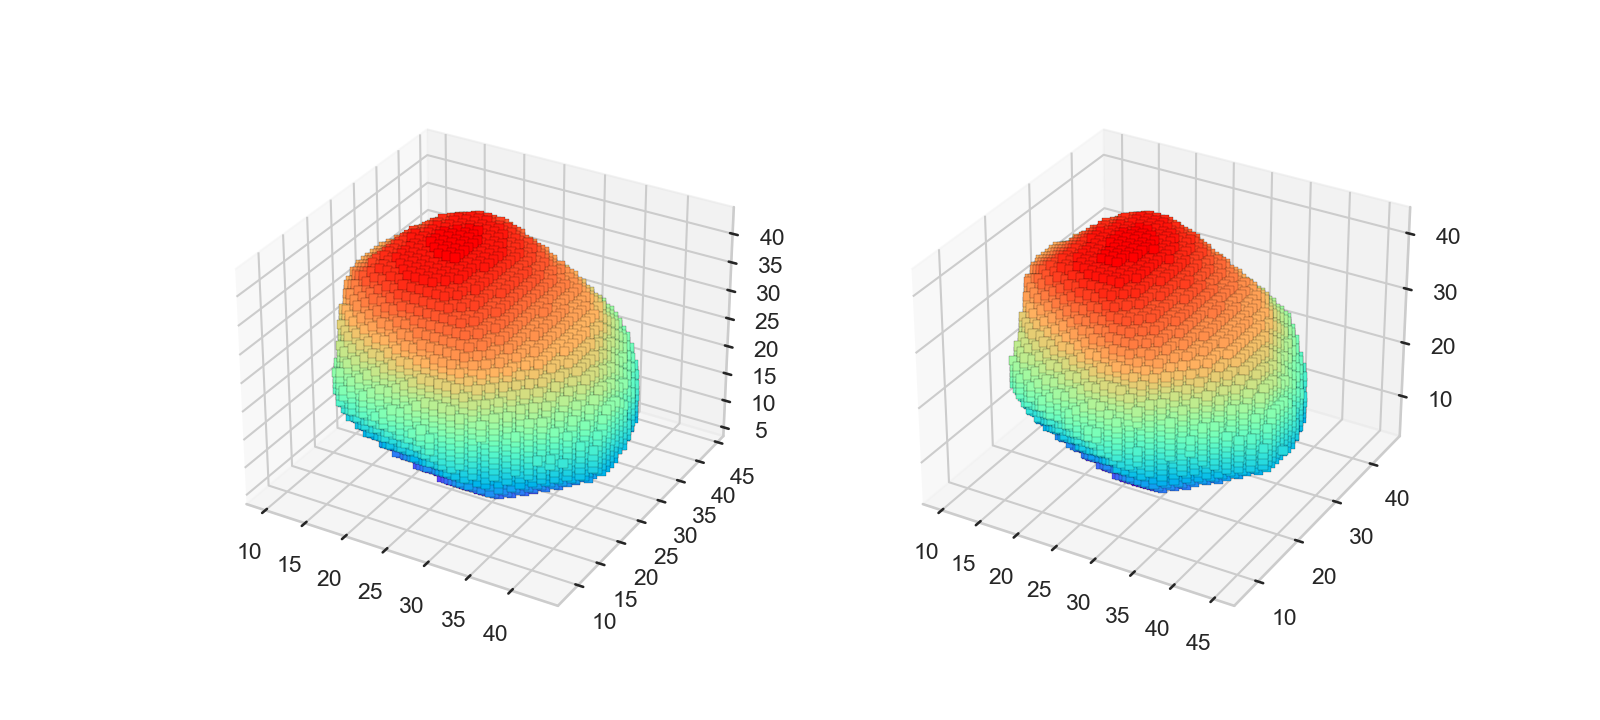

In [52]:
#Visualize shapes
for k in range (int(m/2)):
    compare_spectrums_3D(Y[2*k],Y[2*k+1],big_RY)
